In [ ]:
# Clustering Notebook
# =====================================
# Importar librerías


import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as sch






# =====================================



In [3]:
%load_ext kedro.ipython

df = catalog.load("data_final")

[11/27/25 18:18:43] INFO     Using                                                                  ]8;id=805649;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=373750;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Li                
                             b\site-packages\kedro\framework\project\rich_logging.yml' as logging                  
                             configuration.                                                                        

[11/27/25 18:18:44] INFO     Registered line magic '%reload_kedro'                                   ]8;id=660603;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=988218;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py#63\63]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=380868;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=37782;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py#65\65]8;;\

                    INFO     Resolved project path as:                                              ]8;id=338163;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=88053;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py#180\180]8;;\
                             c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\proyecto                
                             -ml.                                                                                  
                             To set a different path, run '%reload_kedro <project_root>'                           

[11/27/25 18:18:45] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=85009;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=113913;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[11/27/25 18:18:56] DEBUG    Failed to send data to Heap. Exception of type 'ReadTimeout' was raised. ]8;id=957403;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=187627;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro_telemetry\plugin.py#358\358]8;;\

                    INFO     Kedro project proteyecto-ml                                            ]8;id=978678;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=695059;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=93903;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=743443;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py#147\147]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=24176;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=262350;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\ipython\__init__.py#153\153]8;;\

                    INFO     Loading data from data_final (CSVDataset)...                      ]8;id=454597;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=588203;file://c:\Users\droid\Desktop\Rainbow_six_kedro\Rainbow_six_kedro_ml\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

In [4]:
# =====================================
# 2. Preprocesamiento
def preprocess_data(df: pd.DataFrame):
    df_limits = df.head(7000)
    X = df_limits[['mapname', 'operator', 'primaryweapon']]

    encoder = OneHotEncoder(sparse_output=True)
    X_encoded = encoder.fit_transform(X)

    scaler = StandardScaler(with_mean=False)
    X_scaled = scaler.fit_transform(X_encoded)

    X_scaled_df = pd.DataFrame(X_scaled.toarray() if hasattr(X_scaled, "toarray") else X_scaled)
    return X_scaled_df, encoder, scaler

X_scaled, encoder, scaler = preprocess_data(df)
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,5.399012,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.991758,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.991758,0.0,...,0.0,0.0,0.0,0.0,4.268343,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [5]:
# =====================================
# 3. PCA (85% de varianza)
def apply_pca(X_scaled: pd.DataFrame, explained_var: float = 0.85):
    pca = PCA(n_components=explained_var)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca

X_pca, pca_model = apply_pca(X_scaled)


print("Varianza explicada total:", sum(pca_model.explained_variance_ratio_))


Varianza explicada total: 0.865573158729392


In [6]:
# ==== CLUSTERING KMEANS ====

from sklearn.cluster import KMeans

def apply_kmeans(X_pca: pd.DataFrame, n_clusters=5):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(X_pca)
    return labels

# Aplicar KMeans
labels_kmeans = apply_kmeans(X_pca, n_clusters=5)

print("Número de clusters KMeans:", len(set(labels_kmeans)))


Número de clusters KMeans: 5


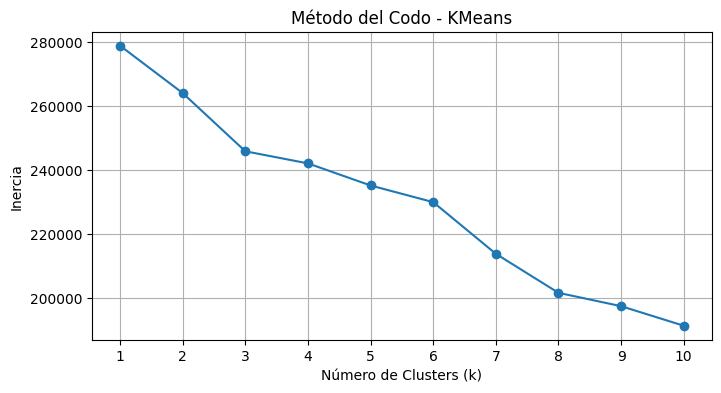

In [ ]:


inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo - KMeans')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [7]:
# ==== MÉTRICAS DE CLUSTERING SOLO KMEANS ====

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def compute_clustering_metrics_kmeans(X_pca, labels_kmeans):
    if len(set(labels_kmeans)) <= 1:
        return {
            "silhouette": None,
            "davies_bouldin": None,
            "calinski_harabasz": None
        }
    return {
        "silhouette": silhouette_score(X_pca, labels_kmeans),
        "davies_bouldin": davies_bouldin_score(X_pca, labels_kmeans),
        "calinski_harabasz": calinski_harabasz_score(X_pca, labels_kmeans)
    }

# Calcular métricas KMeans
metrics_kmeans = compute_clustering_metrics_kmeans(X_pca, labels_kmeans)

# Mostrar como DataFrame
metrics_df = pd.DataFrame([metrics_kmeans], index=["KMeans"])
print(metrics_df)


        silhouette  davies_bouldin  calinski_harabasz
KMeans    0.058275        2.762187         323.893653


In [8]:
# ==== VARIANZA INTRA-CLUSTER SOLO KMEANS ====

def cluster_variance_kmeans(X_pca, labels_kmeans):
    clusters = np.unique(labels_kmeans)
    var_per_cluster = {}

    for c in clusters:
        points = X_pca[labels_kmeans == c]
        var_per_cluster[c] = np.var(points, axis=0).sum()  # suma de varianzas por componente

    return var_per_cluster

# Calcular varianza KMeans
var_kmeans = cluster_variance_kmeans(X_pca, labels_kmeans)

print("Varianza intra-cluster KMeans:", sum(var_kmeans.values()))


Varianza intra-cluster KMeans: 133.47178186838335


In [9]:
# ==== VISUALIZACIÓN PCA 2D SOLO KMEANS ====

# Crear DataFrame con PC1, PC2 y etiquetas KMeans
pca_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
pca_df["cluster"] = labels_kmeans.astype(str)

# Gráfico PCA 2D
fig = px.scatter(
    pca_df,
    x="PC1",
    y="PC2",
    color="cluster",
    opacity=0.6,
    labels={"cluster": "Cluster"},
    title="PCA 2D - Clustering KMeans"
)

fig.update_traces(marker=dict(size=6))
fig.update_layout(height=600, width=800)

fig.show()


In [ ]:
# ANOMALÍAS PARA K-MEANS
from sklearn.metrics import pairwise_distances_argmin_min

# Distancia mínima de cada punto a su centro asignado
_, dist_kmeans = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)

# Clasificamos como anomalías el 5% más lejano
umbral_kmeans = np.percentile(dist_kmeans, 95)
anom_kmeans = dist_kmeans > umbral_kmeans


In [ ]:
# === BARRA DE ANOMALÍAS PARA KMEANS ===
fig.add_trace(
    go.Scatter(
        x=np.arange(len(pca_df)),
        y=[-0.25] * len(pca_df),
        mode="markers",
        marker=dict(
            size=6,
            color=["red" if a else "lightgray" for a in anom_kmeans],
            symbol="square"
        ),
        showlegend=False,
        hovertemplate="Punto %{x}<br>Anomalía (KMeans): %{marker.color}"
    ),
    row=1, col=2
)
